<a href="https://colab.research.google.com/github/Prathamesh-Shanbhag/Week-2_Data_Preprocessing/blob/Assignment-2/Week2_RAVDESS%3C%3ETESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Audio Data**

<center><h1> Introduction to Audio Data Analysis </h1></center>


As a first step towards Speech Emotion Recognition, this notebook serves as an introduction to data cleaning and feature engineering techniques for audio data.In the next notebooks, we will delve into various Machine learning algorithms to develop models to perform classification.

Data cleansing and feature engineering comprise the most crucial aspect of preparing machine and deep learning models alike and is often the difference between success and failure. We can drastically improve the performance of a model with proper attention paid to feature engineering.
For features to be useful in classification they must encompass sufficient variance between different classes.

**Introduction to RAVDESS dataset**

We are going to use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song dataset), created by Steven Livingstone and Frank Russo of Ryerson University. <br>
**Files**
This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

1. Audio-only (03)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12) Female, as the actor ID number is even.

[Details of the RAVDESS dataset](https://psychlabs.torontomu.ca/smartlab/resources/speech-song-database-ravdess/) <br>


The above link has some problems with the dataset,so i cleaned it a bit and you can access it and download it from [this link](https://drive.google.com/drive/folders/1OxhaA7DuOc7UYJZIajFlgshvdWDTLBqy?usp=sharing)

We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB.
Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences with
a variety of emotions and intensity. We get 1440 speech files (24 actors * 60 recordings per actor). Each audio sample has been rated  by a human 10 times for emotional quality.

### Machine Learning Process Overview
1. Feature Engineering: Choose and define the properties which our model will use to evaluate the audio files. <br>
2. Feature Extraction: Compute the features for each audio file and build a feature matrix representing all audio files. <br>
3. Model exploration: Test candidate models that make sense for the properies of the dataset
4. Training the MLP Classifier model: Choose and optimize the properties of our model on validation data - hyperparameters and architechture.  <br>
5. Evaluate our model's performance: Evaluate our model's accuracy on validation data and score it against test data which it has never seen in training.<br>
6. Explore options for improving our model: Is our dataset the right size? Is our model too complex or too simple? <br>

*In this notebook, we are going to focus on first two steps of the process.*
1. *Feature Engineering*
2. *Feature Extraction*

### Feature Engineering
Before building any sort of predictive models, we not only need data - but we need a usable representation. Enter feature engineering.

An audio file can be represented as a time series with the dependent axis being
the amplitude of the audio waveform. The waveform of the sound file is all the information we have with which to create features to train our model. However, the shape of a waveform does not carry enough discriminating information, so we need to transform the waveform into a more useable form. <br>
Sometimes our input dataset _does_ have enough information to train a model to give accurate results - but even then input data should be scrutinized and transformed - this allows us to pick the best model for our features, which is usually much better and different than a model that works on our raw input data.  Proper feature engineering carries advantages not limited to

 - **More accurate, generalizable models**
 - **Insight into model's decision-making behaviour**
 - **Flexibility in choice of models**
 - **Faster training**

**Before feature engineering, we always cleanse our data** - which may consist of removing outliers (carefully), removing irrelevant input data according to business logic, or removing noise. For audio, data cleaning may consistent of making audio samples equal in length and padded with silence at either end. The RAVDESS dataset has done that for us, but this is a rare case.

That being said, let's see what we're starting with by comparing the waveforms of "Happy" and "Angry" of Actor 1:

In [4]:
# Get the critical imports out of the way
!pip install soundfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

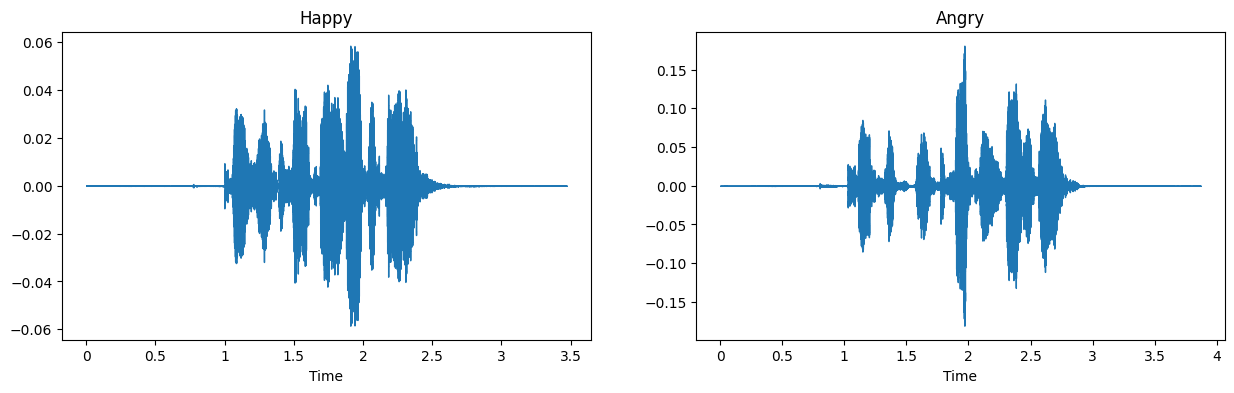

In [ ]:
################# Load Happy and Angry example of Actor 1 #####################################
with soundfile.SoundFile('/content/drive/MyDrive/ColabNotebooks/Actor_01/03-01-03-01-01-01-01.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title('Happy')

with soundfile.SoundFile('/content/drive/MyDrive/ColabNotebooks/Actor_01/03-01-05-01-01-01-01.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title('Angry')

Alright, there's a visible difference - but not enough to classify by emotion. Take my word for it. Try it if you like. However, raw waveforms can be used for certain other audio classification tasks with the right network.

So, where do we get features suitable for emotion classification?
### Short-Time Fourier Transform
The lowest-hanging fruit in time series signal processing is, of course, the Fourier Transform.
Specifically, we'll use the Short-Time Fourier Transform (STFT) which will cut our audio waveform into short, overlapping equal length segments and
take the Fourier transform of each segment individually to produce multiple power spectrograms, identifying resonant frequencies present in our audio file. The major advantage of STFT is better resolution of _changes_ in the audio signal w.r.t. time. <br>

If you want to explore Fourier transform please look into [this article.](https://medium.com/@ongzhixuan/exploring-the-short-time-fourier-transform-analyzing-time-varying-audio-signals-98157d1b9a12)


Let's start visualizing our features to get a better handle on them.
Load a sample audio file from our dataset - each audio file is 3 seconds in length.

In [ ]:
with soundfile.SoundFile('/content/drive/MyDrive/ColabNotebooks/Actor_01/03-01-03-01-01-01-01.wav') as audio:
    happy_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

with soundfile.SoundFile('/content/drive/MyDrive/ColabNotebooks/Actor_01/03-01-05-01-01-01-01.wav') as audio:
    angry_waveform = audio.read(dtype="float32")
    # same sample rate

##### Visualize the combination of power spectrograms output by STFT w.r.t time:

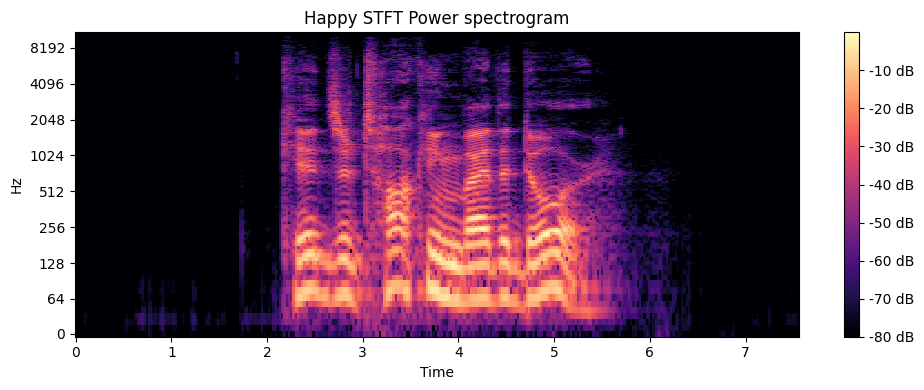

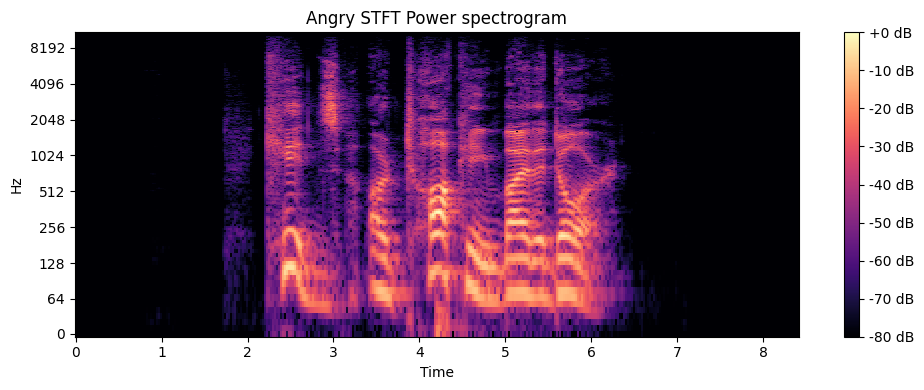

In [ ]:
stft_spectrum_matrix = librosa.stft(happy_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Happy STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(angry_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

We're getting somewhere, but we're going to have to go further. We operate under the assumption that features whose interclass differences we can visualize will be good candidates on which to train a neural network. Looks like further transformations on the STFT will yield good features. Since we have a 3 second audio file, STFT spectrograms for these audio samples combine to show the change in frequencies across a 3 second window.

###Mel-Frequency Cepstral Coefficients
We're going to build on the STFT by using the Mel Frequency Cepstral Coefficients (MFCCs) as a feature.
In brief, MFCC is a mathematical method which transforms the power spectrum of an audio signal to a small number of coefficients representing power of the audio signal in a frequency region (a region of pitch) taken w.r.t. time.
<br><br>
In other words, MFC coefficients give us an idea of the changing pitch of an audio signal.

To understand our major feature a little better, we should at least have a vague idea of the math behind it.
MFCC at its core uses STFT to produce audio power spectrums. We then apply triangular, overlapping window functions to the power spectrograms and take the sum of energy in each window which is essentialy a frequency bin. To determine the number and position of window functions, and width of each frequency bin, we map the frequencies of our audio's power spectrograms to the [Mel scale](https://en.wikipedia.org/wiki/Mel_scale), a nonlinear pitch scale representing the perceived pitch in 'mels' of an audio signal w.r.t. its frequency. The motivation for the mel scale is to account for the way human hearing perceives pitch based on frequency ratios rather than absolute differences in frequencies. The window functions/frequency bins we applied in this step are called mel filterbanks.

Now we can take the log of the sum of power in each mel frequency filterbank. Taking the log power of an audio spectrogram produces a cepstrum - more on this a little later.

###### The Discrete Cosine Transform
Finally, we apply the discrete cosine transform [(DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) to the log of power in each filterbank. The DCT carries distinguished advantages: Because triangular window functions overlap, the mel filterbank energies are correlated with each other; DCT decorellates the signals; DCT produces coefficients such that usually only the top few coefficients are necessary to represent a signal with fair accuracy, i.e. a compressed representation. **In this way, DCT is quite similar to PCA** - one key difference being that DCT has an absolute definition while PCA is only defined w.r.t. a dataset. For this reason (and a couple others) DCT sees a _huge_ range of applicability: image and audio data compression (read: internet, wireless tech, medicine) and cryptography are most notable. Our MFC coefficients are then the amplitudes of each DCT-transformed log filterbank power, taken w.r.t. time.

Another way to think about MFCC is as a deconvolution method to identify periodic, or resonant structures within an audio signal's frequency space. We can visualize our MFC coefficients by plotting the coefficients provided by each mel filterbank against time.

I've found for this task that 40 filterbanks producing 40 coefficients provide the best accuracy and quick computation.

You can further explore the Mel-Frequency Cepstral Coefficients from
 [this article.](https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779)

###### Visualize our sample's MFC coefficients w.r.t time:

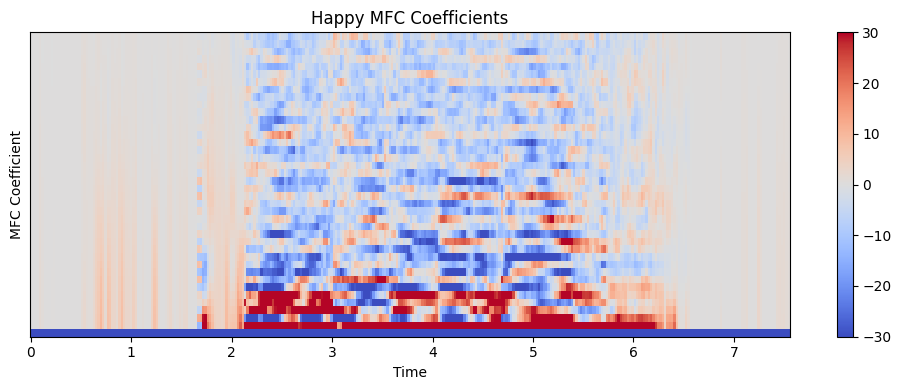

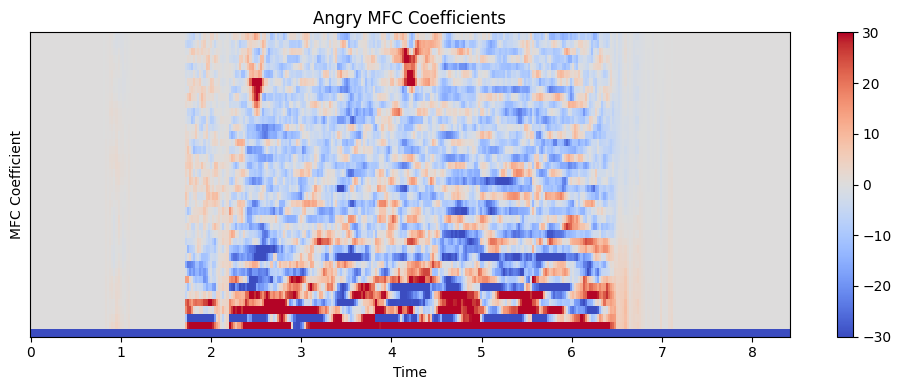

In [ ]:
from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=happy_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Happy MFC Coefficients')
plt.tight_layout()

mfc_coefficients = librosa.feature.mfcc(y=angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Angry MFC Coefficients')
plt.tight_layout()

**Positive MFCCs correspond to low-frequency regions of the cepstrum, and negative MFFCs to high-frequency.**

**We see the Angry voice has a much greater proportion of positive MFFCs, corresponding to a lower voice pitch compared to the Happy voice. Makes sense - a happy voice carries a lighter tone and a higher pitch.**

##### Quick MFCC Derivation
1. Take the square of magnitudes in spectrograms produced by STFT to produce audio power spectrograms for short overlapping frames of the audio signal, <br>
2. Apply a mel-scale-based transformation, mel filterbanks (triangular window functions) to each STFT power spectrogram and sum the power in each filterbank <br>
3. Take the log of each filterbank power <br>
4. Take the discrete cosine transform of each log power in each STFT frame, giving us the MFC coefficients - our measure of power at various mel frequencies, corresponding to audible pitch. <br>

Wikipedia has a pretty straight-forward explanation of [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).



### Mel Spectrograms and Mel-Frequency Cepstrums
In deriving our MFCCs, we have also produced an additional feature we can make use of.
When we mapped the frequencies of a power spectrogram to the mel scale, we produced a Mel Frequency Spectrogram -
a simple analog of the power spectrogram with the frequency scale in mels.
We're going to use the Mel Specotrgrogram as a feature of its own.

##### Visualize our sample's Mel spectrogram w.r.t time:

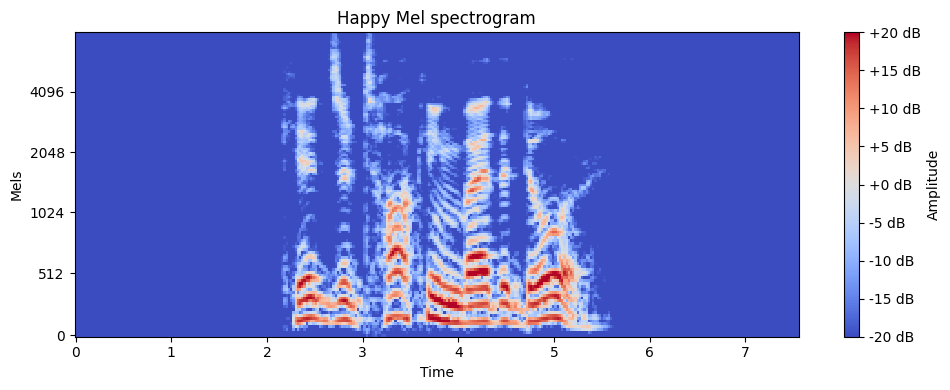

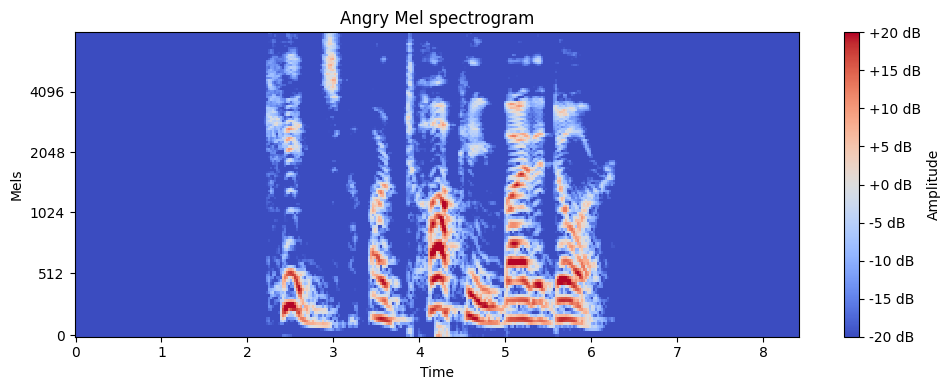

In [ ]:
melspectrogram = librosa.feature.melspectrogram(y=happy_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Happy Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=angry_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Angry Mel spectrogram')
plt.tight_layout()

**The Angry voice produces sharper transitions between mel frequency peaks compared to the Happy voice, which has smoother pitch transitions. That makes intuitive sense - an Angry voice has sharp transitions while a happy voice is more steady and pleasing to the ears. Mel spectrograms will make another good feature.**

What about the cepstrum? When we took the log of the spectral amplitudes in a Mel-scaled power spectrogram, we could have plotted that result as a time series and produced what is known as a 'mel-frequency cepstrum', now in the 'quefrency' domain, so confusingly named because we have applied a transformation to an audio signal in its frequency domain, but have plotted it as a time series - not quite in the frequency domain, not quite in the time domain. In the cepstrum, we observe a peak wherever there is a periodic element in the original audio signal. We've actually already used the the mel-frequency cepstrum (MFC) as a feature, since that is precisely the source of our MFC coefficients. Again, Wikipedia has a fairly palatable explanation of the [cepstrum](https://en.wikipedia.org/wiki/Cepstrum).

Below is an excellent visualization of the transformations between waveform, spectrogram, mel spectrogram, and MFCCs plotted as time series.
The vertical frame in each graph represents a single STFT frame.<br>



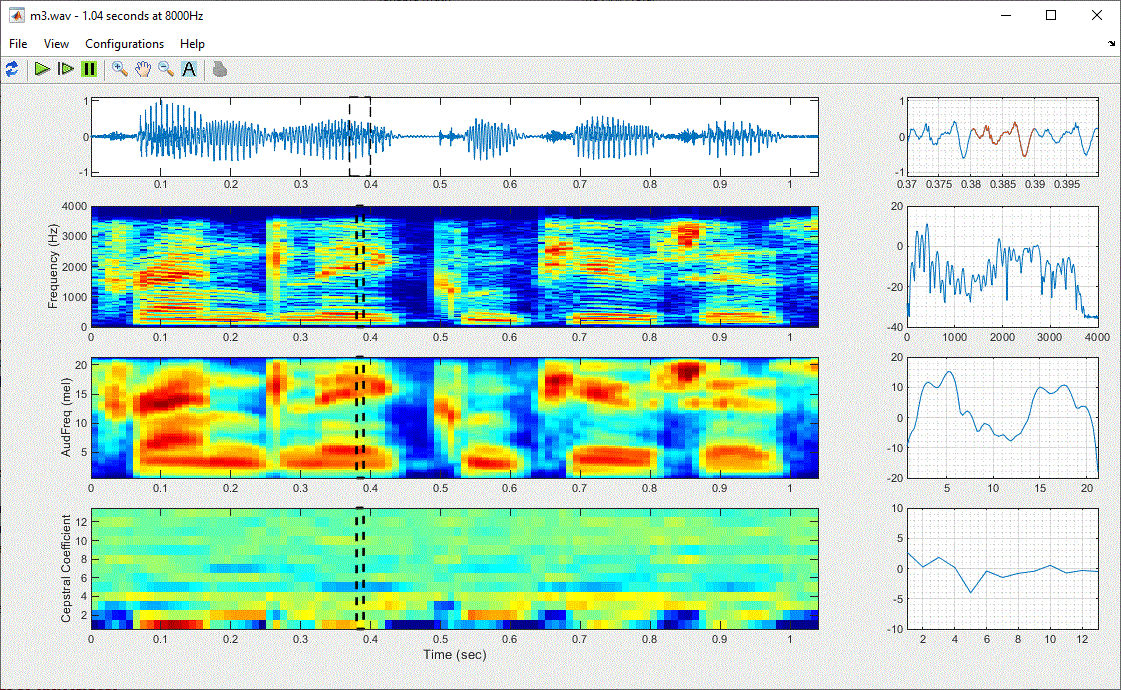

### The Chromagram
To extract an additional feature, we're going to build a chromagram on each power spectrogram computed by STFT. A chromagram is a representation of an audio signal w.r.t. time, mapping audio signal to a pitch class.
Most often, we map to the 12 standard pitch classes (i.e. the musical scale CDEFGAB + 5 semitones gives us 12 pitch classes).
Again, wikipedia has a short and sweet [explanation](https://en.wikipedia.org/wiki/Chroma_feature).


##### Visualize the chromagram for our sample audio:

In [14]:
chromagram = librosa.feature.chroma_stft(y=happy_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Happy Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=angry_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Angry Chromagram')
plt.tight_layout()

NameError: name 'happy_waveform' is not defined

In [ ]:
print(chromagram.shape)

**The pitch distribution of the Angry voice has a much lower dispersion compared to the Happy voice, whose pitch has a higher dispersion at any point in time. This makes intuitive sense considering the tone of an angry voice is more intense and "snappy" compared to a happy voice, which is smoother to the ears - here's a good explanation as to why. This should make a good feature.**

### Feature Extraction
We're going to take full advantage of librosa, a Python library enabling audio analysis and feature extraction.
Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC.
Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try
and have bit more discriminatory power between samples. <br>

Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC**: Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40 which I found to work well

In [12]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    #print(stft_spectrogram.shape)
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(
        librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0
        )
    #print(chromagram.shape)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

We're going to wrap our feature extraction functions so we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we're going to
stack them horizontally to create a single feature array.

In [11]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)
        feature_matrix=np.array([])

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

### Load the Dataset and Compute Features
We have to understand the labelling of the RAVDESS dataset to find the ground truth emotion for each sample.
Each file is labelled with 7 numbers delimited by a "-".
Most of the numbers describe metadata about the audio samples such as their format (video and/or audio),
whether the audio is a song or statement, which of two statements is being read and by which actor.

The third and fourth numbers pertain to the emotional quality of each sample. The third number is in the range of 1-8 with each number representing an emotion.
The fourth number is either 1 or 2, representing normal (1) or strong (2) emotional intensity.

We're going to define a dictionary based on the third number (emotion) and assign an emotion to each number as specified by the RAVDESS dataset:

In [10]:
#Emotions in the RAVDESS dataset
RAVDESSemotions ={
  '01':'neutral',
  # Avoiding the calm emotion as it is missing in the TESS Dataset
  # '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
TESSemotions = {
    "angry": "angry",
    "disgust": "disgust",
    "fear": "fearful",
    "happy": "happy",
    "neutral": "neutral",
    "pleasant": "surprised",
    "sad": "sad",
}

Finally, let's load our entire dataset and compute the features of each audio file:

In [7]:
import os, glob


def load_data():
    X, y, genders = [], [], []
    count = 0
    # Process RAVDESS dataset
    for file in glob.glob("/content/drive/MyDrive/ColabNotebooks/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion_code = file_name.split("-")[2]
        if emotion_code in RAVDESSemotions:
            emotion = RAVDESSemotions[emotion_code]
            gender = "male" if int(file_name.split("-")[6][1]) % 2 else "female"
            features = get_features(file)
            X.append(features)
            y.append(emotion)
            genders.append(gender)
            print(f"\r For RAVDESS, processed - {count} audio samples", end=" ")
        else:
            print(f"Skipping file {file_name} due to unwanted emotion code.")
        count += 1
            # Process TESS dataset
    for folder in glob.glob("/content/drive/MyDrive/ColabNotebooks/TESS/*"):
        for file in glob.glob(f"{folder}/*.wav"):
            folder_name = os.path.basename(folder)
            emotion = TESSemotions[folder_name.split("_")[1].lower()]
            gender = "male" if "OAF" in folder_name else "female"
            features = get_features(file)
            X.append(features)
            y.append(emotion)
            genders.append(gender)
            count += 1
            print(f"\rFor TESS, processed - {count} audio samples", end=" ")

    return np.array(X), np.array(y), np.array(genders)

Compute the feature matrix and read the emotion labels for the entire dataset.
Note that our regressor (independent/explanatory variable), usually denoted X, is named 'features', and our regressand (dependent variable), usually denoted y, is named 'emotions'.

In [15]:
features, emotions, genders = load_data()

For TESS, processed - 2774 audio samples 

In [16]:
features

array([[ 0.54669064,  0.59352297,  0.4232727 , ...,  5.5562787 ,
         8.817527  ,  2.8666143 ],
       [ 0.5319576 ,  0.48005655,  0.39473823, ...,  3.6602235 ,
         5.5270505 ,  4.1154885 ],
       [ 0.41813886,  0.3221309 ,  0.38325363, ...,  5.8194423 ,
         5.438899  , -1.0156647 ],
       ...,
       [ 0.5601372 ,  0.62046874,  0.46998245, ..., -0.31003186,
         2.724206  ,  4.714048  ],
       [ 0.4816211 ,  0.5949753 ,  0.4671651 , ...,  5.9084945 ,
         3.814592  ,  2.1155665 ],
       [ 0.56655365,  0.59793764,  0.42520753, ...,  2.7683623 ,
         4.188586  ,  6.788843  ]], dtype=float32)

Let's see what the features we extracted look like:

In [17]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
features_df


Audio samples represented: 2774
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.546691,0.593523,0.423273,0.295293,0.297999,0.316516,0.353637,0.393840,0.361282,0.339982,...,3.420372,3.305965,4.755129,8.644628,2.627875,6.214300,0.739182,5.556279,8.817527,2.866614
1,0.531958,0.480057,0.394738,0.418671,0.415347,0.474155,0.438585,0.386439,0.364540,0.365529,...,18.371742,11.657659,11.768654,3.180676,2.080669,4.976298,1.517696,3.660223,5.527050,4.115489
2,0.418139,0.322131,0.383254,0.339268,0.344153,0.402635,0.370915,0.302110,0.304978,0.368936,...,21.426218,15.043857,11.023552,7.093488,-1.525644,5.092551,3.906274,5.819442,5.438899,-1.015665
3,0.569951,0.621932,0.507308,0.404352,0.477505,0.448807,0.384460,0.386723,0.419975,0.438008,...,7.761436,8.547413,8.437075,8.798371,-3.947170,0.361059,3.524293,4.786001,5.808592,-1.528697
4,0.624954,0.540780,0.492228,0.401700,0.377179,0.420750,0.414657,0.399573,0.381615,0.424624,...,7.261063,3.654303,7.788413,6.323134,0.689828,5.535823,3.882137,2.537952,5.624636,0.408924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2769,0.500833,0.399227,0.296347,0.332512,0.391352,0.475865,0.442678,0.427374,0.440252,0.322628,...,-3.899641,-0.554710,8.287210,8.020728,9.134341,6.818546,0.895470,4.702924,5.254028,9.479212
2770,0.503450,0.525385,0.372606,0.374780,0.374536,0.449388,0.493325,0.434776,0.481596,0.406240,...,-3.022754,-2.548512,7.154708,5.578468,7.897515,5.154736,3.140874,4.715513,5.857761,9.500685
2771,0.560137,0.620469,0.469982,0.409972,0.416465,0.439411,0.450518,0.441844,0.510179,0.545580,...,-1.665648,3.075390,8.885234,7.699493,4.428883,1.089459,-0.250371,-0.310032,2.724206,4.714048
2772,0.481621,0.594975,0.467165,0.329620,0.354234,0.367403,0.445283,0.462855,0.486925,0.592924,...,3.318197,5.498450,12.115681,6.887001,2.083483,0.829489,1.567219,5.908494,3.814592,2.115566


We have a matrix of dim 1435 x 180. Looks good - 1435 audio samples, one per row, with a series of
180 numerical features for each sample.

**Each of the 1435 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.**

**Analyzing the gender balance**

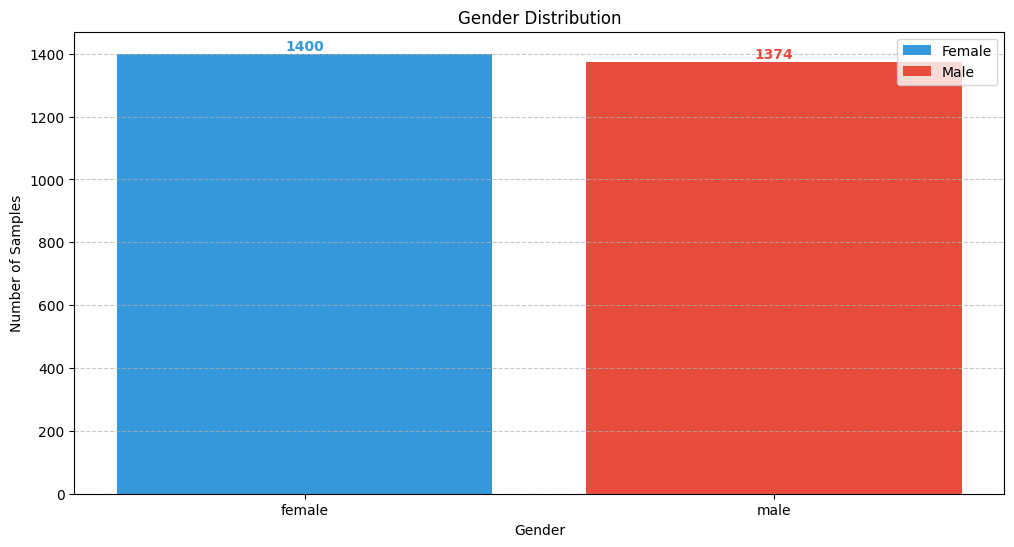

In [18]:
gender_counts = np.unique(genders, return_counts=True)

# Visualizing the gender balance
colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12"]
plt.figure(figsize=(12, 6))
bars = plt.bar(gender_counts[0], gender_counts[1], color=colors)

plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Samples")

# Adding a legend.
gender_labels = ["Female", "Male"]
plt.legend(bars, gender_labels, loc="upper right")

# Adding a grid.
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adding annotations to each bar
for i, count in enumerate(gender_counts[1]):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom", fontweight="bold", color=colors[i])

plt.show()


Let's see the class balance of our dataset:

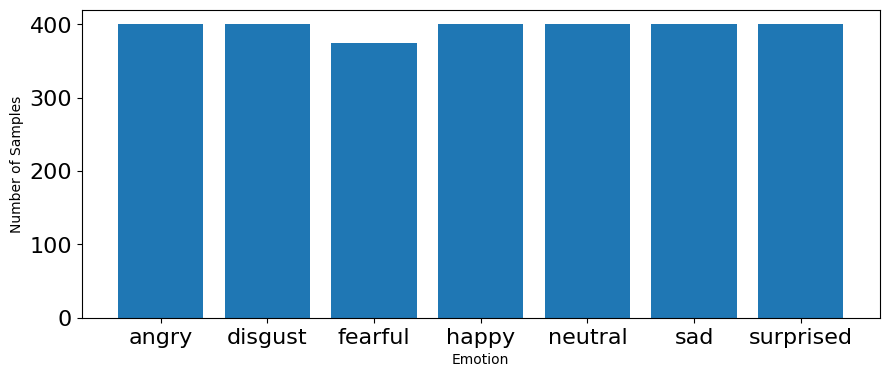

In [19]:
# plot emotions
plt.figure(figsize=(35, 4))
plt.subplot(1, 3, 1)
# np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(7), height=count)
plt.xticks(ticks=range(7), labels=[emotion for emotion in emotion_list], fontsize=10)
plt.xlabel("Emotion")
plt.tick_params(labelsize=16)
plt.ylabel("Number of Samples")
plt.show()

**Great, the classes appear to be balanced. That makes the task easier.** All emotions _except_ the neutral class have a "strong" intensity so there are half as many neutral samples. That might have an impact.

### Feature Scaling
To properly train most machine learning models on _most_ datasets, we first need to scale our features. **This is crucial for models which compute distances between data, and especially critical for DNNs**: If there is a difference in the variance of features simply because of their possible range of values, then a model will learn that the features with the greatest variance are the most important. However, **differences in the variance of unscaled features belonging to different and unknown distributions is an inappropriate measure of importance.** Let's check our features' properties:

In [ ]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:, :11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(
        f"12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}"
    )

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:, 12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(
        f"\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}"
    )

    # Check MFCC feature values
    features_df_mfcc = df.loc[:, 140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(
        f"\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}"
    )


print_features(features_df)

12 Chromagram features:           min = 0.154,     max = 0.936,     mean = 0.471,     deviation = 0.106

128 Mel Spectrogram features:     min = 0.000,     max = 125.347,     mean = 0.452,     deviation = 2.204

40 MFCC features:                 min = -586.171,    max = 120.333,    mean = -7.703,    deviation = 66.638


**There's an obvious imbalance in the variance our features; Our features indeed belong to very different distributions:** our MFC coefficients' deviation is greater than the other features by orders of magnitude. That does not mean MFC coefficients are the most important feature, but rather it is a property of the way they are computed.  We will certainly need to scale this feature set.

We have the choice of sklearn's StandardScaler and MinMaxScaler. Standard scaling subtracts the mean of each feature and divides it by the standard deviation of that feature, producing features with mean at zero and unit variance - that is, a variance and standard deviation of 1. Min-Max scaling transforms each feature to be within a bounded interval that we specify.

In practice, **MinMax scaling is especially useful when we know our features should be in a bounded interval**, such as pixel values in [0,255], while **standard scaling is perhaps more practical for features with unknown distributions** because centering the features at zero-mean with a standard deviation of 1 means extreme values will have less of an impact on the model's learned weights, i.e. the model is less sensitive to outliers.

We'll create MinMax scaled features as well so we can give them a try later on to confirm that standard scaling is better in the absence of knowledge on the appropriate distribution for a dataset's features.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)


Make sure our features are properly scaled:

In [ ]:
print("\033[1m" + "Standard Scaling:\n" + "\033[0m")
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print("\n\n\033[1m" + "MinMax Scaling:\n" + "\033[0m")
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -3.122,     max = 5.073,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.625,     max = 39.941,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -3.852,    max = 5.829,    mean = -0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.450,     deviation = 0.163

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.021,     deviation = 0.063

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.410,    deviation = 0.192


Perfect. Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling - a default when we don't specify values. We can now move on to building predictive models for these features.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
